# Medical Imaging Preprocessing

> A walk-through tutorial how to process, manipulate, and save medical images. 
- toc: true
- use_math: true
- comments: true
- use_plotly: true

- read dicom
- metadata
- resampling
- segmentation (by HU)

In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pydicom

from pathlib import Path

In [2]:
PATH = 'data/LIDC-IDRI/'

In [3]:
patients = os.listdir(PATH)
patients.sort()
print(patients.pop(0))
patients

.ipynb_checkpoints


['LIDC-IDRI-0001',
 'LIDC-IDRI-0002',
 'LIDC-IDRI-0003',
 'LIDC-IDRI-0004',
 'LIDC-IDRI-0005',
 'LIDC-IDRI-0006',
 'LIDC-IDRI-0007',
 'LIDC-IDRI-0008',
 'LIDC-IDRI-0009',
 'LIDC-IDRI-0010',
 'LIDC-IDRI-0011']

In [5]:
# not all patient sub-folders contain CT scan, sometimes they're RTSTRUCTs 

patient_path = []
for p in patients:
    patient_directory = glob.glob(f"{PATH}/{p}/**/")
    for mod in patient_directory:
        mod_files = glob.glob(f"{mod}/**/**")
        if len(mod_files) > 10: patient_path.append(mod)
patient_path

['data/LIDC-IDRI//LIDC-IDRI-0001/01-01-2000-NA-NA-30178/',
 'data/LIDC-IDRI//LIDC-IDRI-0002/01-01-2000-NA-NA-98329/',
 'data/LIDC-IDRI//LIDC-IDRI-0003/01-01-2000-NA-NA-94866/',
 'data/LIDC-IDRI//LIDC-IDRI-0004/01-01-2000-NA-NA-91780/',
 'data/LIDC-IDRI//LIDC-IDRI-0005/01-01-2000-NA-NA-42125/',
 'data/LIDC-IDRI//LIDC-IDRI-0006/01-01-2000-NA-NA-92500/',
 'data/LIDC-IDRI//LIDC-IDRI-0007/01-01-2000-NA-NA-81781/',
 'data/LIDC-IDRI//LIDC-IDRI-0008/01-01-2000-NA-NA-30141/',
 'data/LIDC-IDRI//LIDC-IDRI-0009/01-01-2000-NA-NA-07045/',
 'data/LIDC-IDRI//LIDC-IDRI-0010/01-01-2000-NA-NA-43375/',
 'data/LIDC-IDRI//LIDC-IDRI-0011/01-01-2000-NA-NA-73568/']

In [6]:
def load_scan(path):
    slices = [pydicom.read_file(f"{s}") for s in glob.glob(f"{path}/**/*.dcm")]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    return slices

In [9]:
scan = load_scan(patient_path[0])
scan

[Dataset.file_meta -------------------------------
 (0002, 0000) File Meta Information Group Length  UL: 206
 (0002, 0001) File Meta Information Version       OB: b'\x00\x01'
 (0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
 (0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.14519.5.2.1.6279.6001.227129408140157230270926028555
 (0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
 (0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.22213.1.143
 (0002, 0013) Implementation Version Name         SH: '0.5'
 (0002, 0016) Source Application Entity Title     AE: 'POSDA'
 -------------------------------------------------
 (0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
 (0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
 (0008, 0016) SOP Class UID                       UI: CT Image Storage
 (0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.14519.5.2.1.6

Our ```scan``` contains a list of ```pydicom.dataset.FileDataset``` objects. You can check what this class does through the pydicom documentation or with ```??pydicom.dataset.FileDataset```, but briefly it allows us to read and write DICOM files easily. Our DICOM files comprise of several elements that will be of use to us. Some important data elements we'll use are  ```Modality, RescaleIntercept, RescaleSlope, PixelSpacing, SliceThickness,``` and ```ImagePositionPatient```. These data elements are very important since we might notice some subtleties in the scan based on the different manufacturers. We'll also need to process our raw DICOM scan based on these elements. It could also be helpful to use these data elements and construct an array of metadata elements to use for training. The [DICOM library](https://www.dicomlibrary.com/dicom/dicom-tags/) has an exhaustive list of all the data elements and they're use.

In [13]:
# ??pydicom.dataset.FileDataset

In [12]:
type(scan[0])

pydicom.dataset.FileDataset

In [7]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

In [8]:
scan_data = get_pixels_hu(scan)
scan_data.shape

(133, 512, 512)

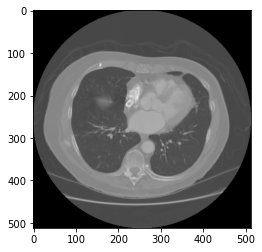

In [11]:
plt.imshow(scan_data[65,...], cmap=plt.cm.gray)